In [77]:
import pandas as pd
import numpy as np
from scipy import stats
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [78]:
#helper functions
def ATR(DF, n=14):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df["H-L"] = df["High"] - df["Low"]
    df["H-PC"] = abs(df["High"] - df["Adj Close"].shift(1))
    df["L-PC"] = abs(df["Low"] - df["Adj Close"].shift(1))
    df["TR"] = df[["H-L", "H-PC", "L-PC"]].max(axis=1, skipna=False)
    df["ATR"] = df["TR"].ewm(com=n, min_periods=n).mean()
    return df["ATR"]

def ADX(DF, n=20):
    "function to calculate ADX"
    df = DF.copy()
    df["ATR"] = ATR(DF, n)
    df["upmove"] = df["High"] - df["High"].shift(1)
    df["downmove"] = df["Low"].shift(1) - df["Low"]
    df["+dm"] = np.where((df["upmove"] > df["downmove"]) & (df["upmove"] > 0), df["upmove"], 0)
    df["-dm"] = np.where((df["downmove"] > df["upmove"]) & (df["downmove"] > 0), df["downmove"], 0)
    df["+di"] = 100 * (df["+dm"] / df["ATR"]).ewm(alpha=1/n, min_periods=n).mean()
    df["-di"] = 100 * (df["-dm"] / df["ATR"]).ewm(alpha=1/n, min_periods=n).mean()
    df["ADX"] = 100 * abs((df["+di"] - df["-di"]) / (df["+di"] + df["-di"])).ewm(alpha=1/n, min_periods=n).mean()
    return df["ADX"]

def RSI(DF, n=14):
    "function to calculate RSI"
    df = DF.copy()
    df["change"] = df["Adj Close"] - df["Adj Close"].shift(1)
    df["gain"] = np.where(df["change"]>=0, df["change"], 0)
    df["loss"] = np.where(df["change"]<0, -1*df["change"], 0)
    df["avgGain"] = df["gain"].ewm(alpha=1/n, min_periods=n).mean()
    df["avgLoss"] = df["loss"].ewm(alpha=1/n, min_periods=n).mean()
    df["rs"] = df["avgGain"]/df["avgLoss"]
    df["rsi"] = 100 - (100/ (1 + df["rs"]))
    return df["rsi"]

def MACD(DF, a=12 ,b=26, c=9):
    """function to calculate MACD
       typical values a(fast moving average) = 12; 
                      b(slow moving average) =26; 
                      c(signal line ma window) =9"""
    df = DF.copy()
    df["ma_fast"] = df["Adj Close"].ewm(span=a, min_periods=a).mean()
    df["ma_slow"] = df["Adj Close"].ewm(span=b, min_periods=b).mean()
    df["macd"] = df["ma_fast"] - df["ma_slow"]
    df["signal"] = df["macd"].ewm(span=c, min_periods=c).mean()
    return df[["macd", "signal"]]

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["return"] = df["Adj Close"].pct_change()
    df["cum_return"] = (1+df["return"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    return (df["drawdown"]/df["cum_roll_max"]).max()

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    df["daily_ret"] = DF["Adj Close"].pct_change()
    vol = df["daily_ret"].std() * np.sqrt(252)
    return vol

In [79]:
# Load the dataset
df = pd.read_csv('SP500_with_indicators_^GSPC.csv').dropna()  # Replace with your dataset file name
df['Date'] = pd.to_datetime(df['Date'])  # Ensure 'Date' is in datetime format
df.set_index('Date', inplace=True)  # Set 'Date' as the index

# Features and target
features = df.columns.drop(['Close', 'Adj Close'])  # Exclude the target variable and redundant columns
target = 'Close'

X = df[features]
y = df[target]

# Normalize the features for better model performance
# Select only numeric features
X_numeric = X.select_dtypes(include=[np.number])

# Handle missing values
X_numeric = X_numeric.dropna()  # Or use X_numeric = X_numeric.dropna()

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Convert the scaled data back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X_numeric.columns, index=X_numeric.index)

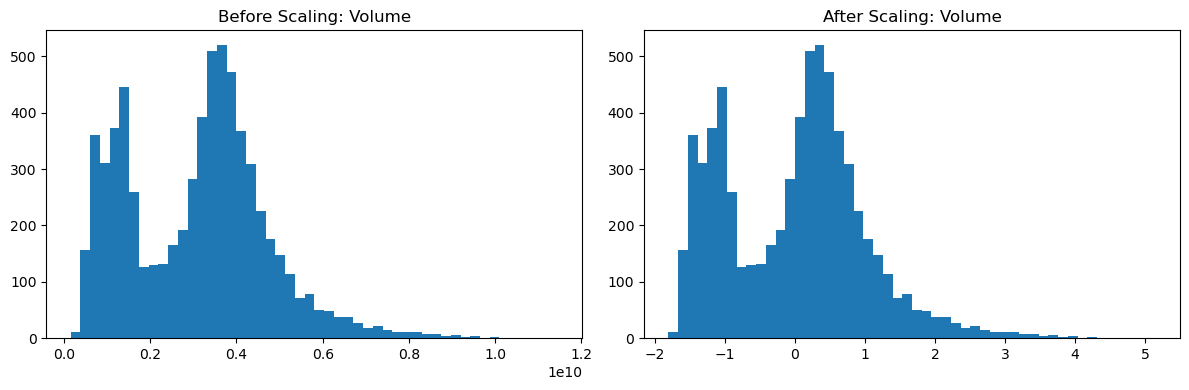

In [80]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(X['Volume'], bins=50)
plt.title('Before Scaling: Volume')

plt.subplot(1, 2, 2)
plt.hist(X_scaled_df['Volume'], bins=50)
plt.title('After Scaling: Volume')

plt.tight_layout()
plt.show()

In [81]:
# Forward Validation Function
def forward_validation(df, initial_train_size, step_size, model_params):
    """
    Perform forward validation for time-series data.
    """
    predictions = []
    actuals = []
    dates = []
    n_splits = (len(df) - initial_train_size) # step_size

    model = xgb.XGBRegressor(**model_params)

    for i in range(n_splits):
        train_start = 0
        train_end = initial_train_size + i * step_size
        test_start = train_end
        test_end = test_start + step_size

        X_train, y_train = X_scaled_df.iloc[train_start:train_end], y.iloc[train_start:train_end]
        X_test, y_test = X_scaled_df.iloc[test_start:test_end], y.iloc[test_start:test_end]
        dates.extend(df.index[test_start:test_end])

        # Train the model
        model.fit(X_train, y_train)

        # Predict on the test set
        preds = model.predict(X_test)
        predictions.extend(preds)
        actuals.extend(y_test)

    return predictions, actuals, dates, model



In [83]:
# Define forward validation parameters
initial_train_size = 1000  # Initial training set size
step_size = 100  # Step size for moving train-test splits
model_params = {"n_estimators": 100, "learning_rate": 0.1, "max_depth": 5, "random_state": 42}

# Perform forward validation
predictions, actuals, dates, model = forward_validation(df, initial_train_size, step_size, model_params)




Model Performance Metrics with Forward Validation:
R-squared Score: 0.9934
Root Mean Square Error (RMSE): 88.1653
Mean Absolute Error: 40.5284
Mean Prediction Accuracy: 97.99%


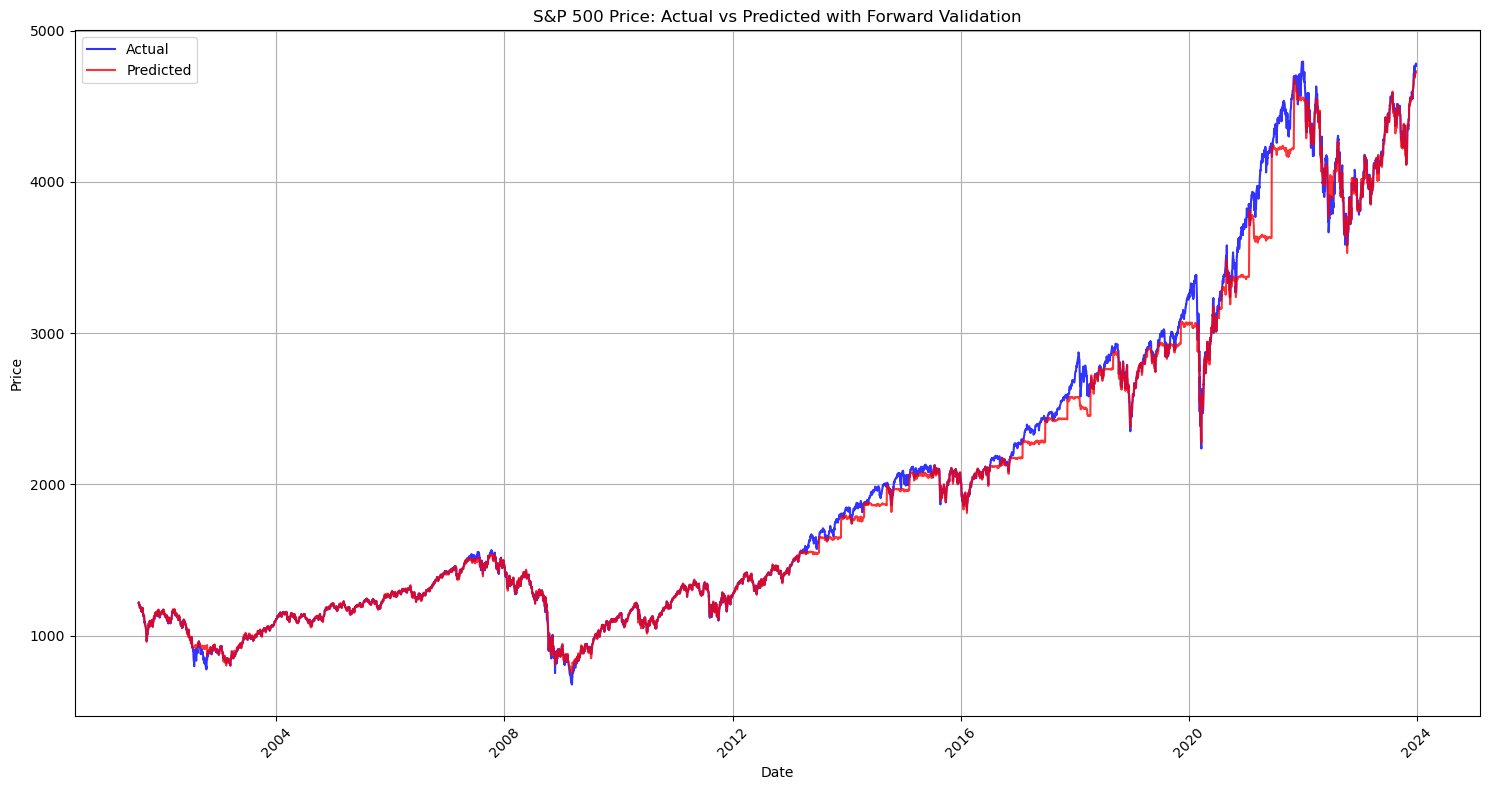

In [84]:
# Calculate performance metrics
test_rmse = mean_squared_error(actuals, predictions, squared=False)
test_r2 = r2_score(actuals, predictions)
test_mae = mean_absolute_error(actuals, predictions)

mean_prediction_accuracy = 100 * (1 - test_mae / np.mean(actuals))

print("\nModel Performance Metrics with Forward Validation:")
print(f"R-squared Score: {test_r2:.4f}")
print(f"Root Mean Square Error (RMSE): {test_rmse:.4f}")
print(f"Mean Absolute Error: {test_mae:.4f}")
print(f"Mean Prediction Accuracy: {mean_prediction_accuracy:.2f}%")

# Plot actual vs predicted values
plt.figure(figsize=(15, 8))
plt.plot(dates, actuals, label='Actual', color='blue', alpha=0.8)
plt.plot(dates, predictions, label='Predicted', color='red', alpha=0.8)
plt.title('S&P 500 Price: Actual vs Predicted with Forward Validation')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

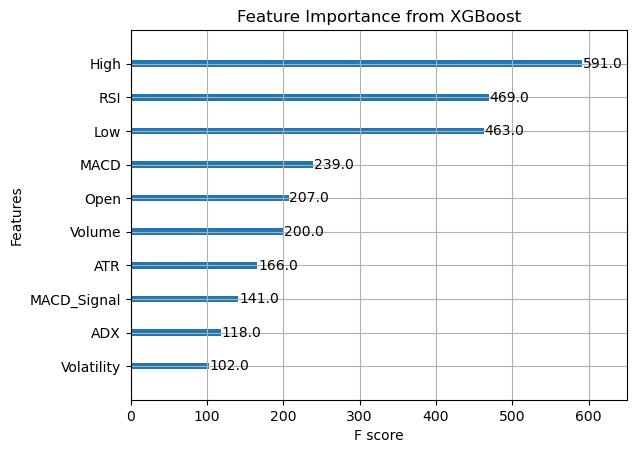

         Feature  Importance
1           High       591.0
6            RSI       469.0
2            Low       463.0
7           MACD       239.0
0           Open       207.0
3         Volume       200.0
4            ATR       166.0
8    MACD_Signal       141.0
5            ADX       118.0
9     Volatility       102.0
10  Max_Drawdown        46.0


In [85]:
# Plot feature importance
plt.figure(figsize=(12, 6))
plot_importance(model, importance_type='weight', max_num_features=10)  # Use `weight`, `gain`, or `cover` to see different views of importance
plt.title('Feature Importance from XGBoost')
plt.show()

# Get feature importance scores
importance = model.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame({'Feature': list(importance.keys()), 'Importance': list(importance.values())})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display importance scores
print(importance_df)

Based on the feature importance matrix. ATR and ADX can be removed from the feature list. Because ATR and ADX are computed by other features in the feature list, like 'high' and 'low' which have higher impact on the prediction than themselves. So for easier prediction, we'll get rid of them.

In [86]:
X_scaled_df = X_scaled_df.drop(columns=['ATR', 'ADX'])
df = df.drop(columns=['ATR', 'ADX'])

In [87]:
# Forward Validation Function
def forward_validation_after_FS(df, initial_train_size, step_size, model_params):
    """
    Perform forward validation for time-series data.
    """
    predictions = []
    actuals = []
    dates = []
    n_splits = (len(df) - initial_train_size) # step_size

    model = xgb.XGBRegressor(**model_params)

    for i in range(n_splits):
        train_start = 0
        train_end = initial_train_size + i * step_size
        test_start = train_end
        test_end = test_start + step_size

        X_train, y_train = X_scaled_df.iloc[train_start:train_end], y.iloc[train_start:train_end]
        X_test, y_test = X_scaled_df.iloc[test_start:test_end], y.iloc[test_start:test_end]
        dates.extend(df.index[test_start:test_end])

        # Train the model
        model.fit(X_train, y_train)

        # Predict on the test set
        preds = model.predict(X_test)
        predictions.extend(preds)
        actuals.extend(y_test)

    return predictions, actuals, dates, model



In [88]:
# Train the model after the feature selection
initial_train_size = 1000  # Initial training set size
step_size = 100  # Step size for moving train-test splits
model_params = {"n_estimators": 100, "learning_rate": 0.1, "max_depth": 7, "random_state": 42}

# Perform forward validation
predictions, actuals, dates, model = forward_validation_after_FS(df, initial_train_size, step_size, model_params)




Model Performance Metrics with Forward Validation after Feature Selection:
R-squared Score: 0.9932
Root Mean Square Error (RMSE): 89.5309
Mean Absolute Error: 41.4723
Mean Prediction Accuracy: 97.94%


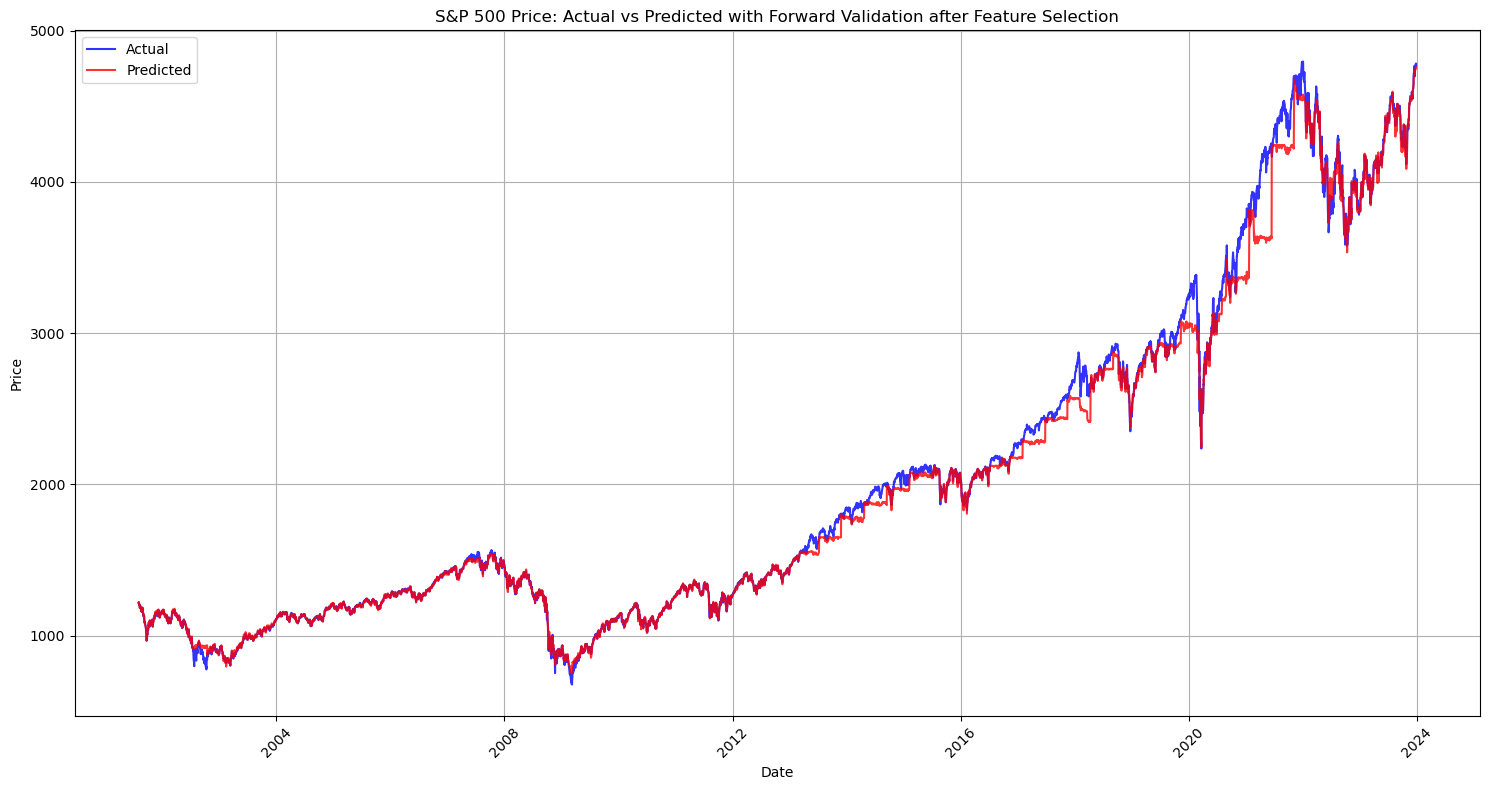

In [89]:
# Calculate performance metrics after feature selection
test_rmse = mean_squared_error(actuals, predictions, squared=False)
test_r2 = r2_score(actuals, predictions)
test_mae = mean_absolute_error(actuals, predictions)

mean_prediction_accuracy = 100 * (1 - test_mae / np.mean(actuals))

print("\nModel Performance Metrics with Forward Validation after Feature Selection:")
print(f"R-squared Score: {test_r2:.4f}")
print(f"Root Mean Square Error (RMSE): {test_rmse:.4f}")
print(f"Mean Absolute Error: {test_mae:.4f}")
print(f"Mean Prediction Accuracy: {mean_prediction_accuracy:.2f}%")

# Plot actual vs predicted values
plt.figure(figsize=(15, 8))
plt.plot(dates, actuals, label='Actual', color='blue', alpha=0.8)
plt.plot(dates, predictions, label='Predicted', color='red', alpha=0.8)
plt.title('S&P 500 Price: Actual vs Predicted with Forward Validation after Feature Selection')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [116]:
# Define the number of future steps to predict
future_steps = 2  # Predicting 100 future days

# Use the last known data point from the training set
last_known_data = X_scaled_df.iloc[-1].to_frame().T

# Prepare a DataFrame to store future predictions
future_predictions_df = df.copy()

#prepare the data for future predictions
future_predictions_X = future_predictions_df.drop(columns=['Close', 'Adj Close'])

# Normalize the features for better model performance
# Select only numeric features
# future_X_numeric = future_predictions_X.select_dtypes(include=[np.number])

# # Handle missing values
# future_X_numeric = future_X_numeric.dropna()  # Or use future_X_numeric = future_X_numeric.dropna()

# # Normalize the features
# scaler = StandardScaler()
# future_X_scaled = scaler.fit_transform(future_X_numeric)

# # Convert the scaled data back to a DataFrame
# future_X_scaled_df = pd.DataFrame(future_X_scaled, columns=future_X_numeric.columns, index=future_X_numeric.index)




In [117]:
for step in range(future_steps):

    # Predict the next value
    next_pred = model.predict(future_predictions_X)[0]

    # Create a new row for the predicted data
    next_row = last_known_data.iloc[-1].copy()
    next_row['Adj Close'] = next_pred

    # Append this new row to the DataFrame to be used for recalculating indicators
    future_predictions_df = future_predictions_df.append(next_row, ignore_index=True)

    # Update indicators
    future_predictions_df['RSI'] = RSI(future_predictions_df)
    macd_df = MACD(future_predictions_df)
    future_predictions_df['MACD'] = macd_df['macd']
    future_predictions_df['MACD_Signal'] = macd_df['signal']
    future_predictions_df["Volatility"] = future_predictions_df["Adj Close"].rolling(window=252).apply(lambda x: volatility(pd.DataFrame({'Adj Close': x})))
    future_predictions_df["Max_Drawdown"] = future_predictions_df["Adj Close"].rolling(window=252).apply(lambda x: max_dd(pd.DataFrame({'Adj Close': x})))

    # Prepare the updated feature set for the next iteration
    last_known_data = future_predictions_df.iloc[[-1]]

# # Generate future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_steps + 1, closed='right')

# # Extract future predictions to plot
predicted_prices = future_predictions_df.iloc[-future_steps:]['Adj Close']
predicted_prices.index = future_dates

#print the future predictions
print(predicted_prices)

# # Plot future predictions
# plt.figure(figsize=(15, 8))
# plt.plot(df.index[-100:], df[target].iloc[-100:], label='Recent Historical Data', color='blue', alpha=0.8)
# plt.plot(predicted_prices.index, predicted_prices, label='Future Predictions', color='red', alpha=0.8)
# plt.title('S&P 500 Price: Future Predictions for the Next 30 Days')
# plt.xlabel('Date')
# plt.ylabel('Predicted Price')
# plt.legend()
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


/var/folders/dk/cq9pwlmd3xsd_h6fgk93nxw80000gn/T/ipykernel_55553/1238844623.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  future_predictions_df = future_predictions_df.append(next_row, ignore_index=True)
/var/folders/dk/cq9pwlmd3xsd_h6fgk93nxw80000gn/T/ipykernel_55553/1238844623.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  future_predictions_df = future_predictions_df.append(next_row, ignore_index=True)


2023-12-30    4688.018555
2023-12-31    4688.018555
Freq: D, Name: Adj Close, dtype: float64


/var/folders/dk/cq9pwlmd3xsd_h6fgk93nxw80000gn/T/ipykernel_55553/1238844623.py:26: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(start=last_date, periods=future_steps + 1, closed='right')
